# Autoreload 2

In [1]:
%load_ext autoreload
%autoreload 2

# Import Relevant Libraries

In [2]:
import pandas as pd
import datetime
from datetime import timezone
import json
import numpy as np
from pandas.io.json import json_normalize
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from math import pi
import time 
import pickle

from nintendo.nintendo_functions_2 import (   #for api use
    fetch_from_cache_or_api, 
    get_token, 
    get_tweets, 
    store_many_tweets, 
    store_response_tweets, 
    tweet_coll)

from nintendo.trend_radar_functions import (   #for post cleaning
    reset_index, 
    json_to_df, 
    combine_2_dfs,
    add_time_to_df,
    unique_seconds_list, 
    second_groupings, 
    seconds_dict, 
    unique_words_list,
    vectorize_to_df,
    words_df,
    trend_line,
    trend_line_19,
    drop_time_from_df,
    create_dictionary_for_specified_time,
    create_dictionary_for_specified_time_19,
    top_5_dict_to_df,
    top_5_dict_to_df_19,
    radar_plot_creator,
    radar_plot_creator_19,
    completed_words_df,
    trend_function,
    radar_function,
    automating_radar_plots,
    )  

from nintendo.data_cleaning import (  #for cleaning
    two_series_to_dict,
    two_series_to_dict_cristian,
    specific_time_slots,
    create_timestamp_col,
    add_time_from_created,
    create_time_col_19,
    select_relevant_cols, 
    select_relevant_cols_19,
    filter_lang,
    filter_lang_19,
    drop_duplicates,
    unique_hashtag_list,
    unique_link_list,
    unique_ats_list,
    remove_hash_link_at,
    strip_punctuation,
    remove_punctuation,
    make_lower_case,
    get_wordnet_pos,
    lemmatize_text,
    remove_stop_words,
    remove_just_hash,
    vader_sentiment,
   )

# Pulls 100 Tweets at a Time (no repeats)

In [3]:
#store_many_tweets(limit=20)

# View Pulled Tweets in Mongo DB

In [4]:
tweet_coll.count_documents({})

10269

'tweets' (below) is a json file

In [5]:
tweets = list(tweet_coll.find())

# Data Cleaning

Flatten JSON File for embedded dictionaries and store as DF.

In [6]:
tweets_norm = json_to_df(tweets)

Filter for English only (also uses only relevant columns)  
Remove any duplicate rows.

In [7]:
df = filter_lang_19(tweets_norm)

In [8]:
df = drop_duplicates(df)

Add a .time. column showing H:M:S (string)

In [9]:
add_time_from_created(df)

Add a datetime column showing H:M:S (datetime)

In [10]:
create_time_col_19(df)

#### Explore the Data

In [11]:
len(df)

10160

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10160 entries, 0 to 10268
Data columns (total 6 columns):
user.id       10160 non-null int64
text          10160 non-null object
lang          10160 non-null object
created_at    10160 non-null object
.time.        10160 non-null object
datetime      10160 non-null object
dtypes: int64(1), object(5)
memory usage: 555.6+ KB


In [13]:
df.isna().sum()

user.id       0
text          0
lang          0
created_at    0
.time.        0
datetime      0
dtype: int64

In [14]:
print(df['.time.'].min())
print(df['.time.'].max())

16:07:00
17:04:59


#### Text Cleaning

Remove any words starting with: #, @, or http and put cleaned text into new 'text2' column.

In [15]:
remove_hash_link_at(df)

Remove punctuation & stop words, make text all lower case, lemmatize all words.

In [16]:
remove_punctuation(df)

In [17]:
make_lower_case(df)

In [18]:
lemmatize_text(df)

In [19]:
remove_stop_words(df)

Remove http again (some links may have had symbol infront of it and not been removed the first time)

In [20]:
remove_just_hash(df)

In [21]:
df = reset_index(df)

# End Data Cleaning

# Vader Sentiment

In [22]:
vader_output = vader_sentiment(df)

In [23]:
vader_output[0:6]

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'compound': 0.1027},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'compound': 0.1027},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

# End Vader Sentiment

# Initial Setup for Graphs

Combine vader sentiments into df

In [24]:
df = combine_2_dfs(reset_index(df),json_to_df(vader_output))

List of every unique second in the data

In [25]:
df = df.sort_values(by='.time.')

# Automating Trend Lines

Note: Trend lines do NOT include empty seconds

# LSM - Maybe try getting neg inverted to neg & Group by 5 seconds?

In [ ]:
unique_sec_list = unique_seconds_list(df)

In [ ]:
#df[str(5)+'_seconds'] = df['.time.'].map(seconds_dict(5, unique_sec_list))

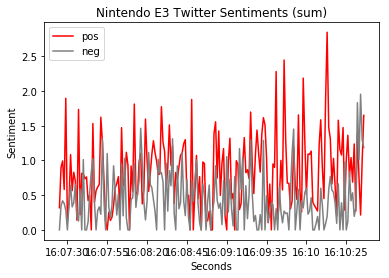

In [29]:
trend_line_19(df, 
                start_time_str='16:07:24', 
                end_time_str='16:10:36',
                sum_mean='sum'
                )

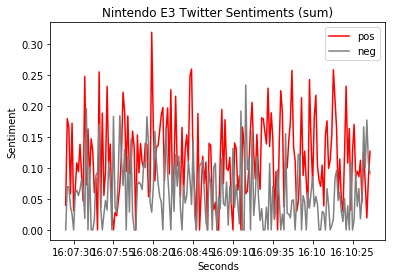

In [30]:
trend_line_19(df, 
                start_time_str='16:07:24', 
                end_time_str='16:10:36',
                sum_mean='mean'
                )

# Specific Time and Time Lengths

### To be used for automation in 2018 as well

Luigi's Mansion = 07:25 through 10:45   
Link's Awakening = 12:50 through 14:55   
Cadence of Hyrule = 32:30 through 33:25   
Breath of the Wild = 42:55 through 43:45   

### LSM -- ISSUE -- two_series_to_dict function is NOT WORKING correctly.. it is dropping thousands of tweets in the zip process.

# CRISTIAN SOLVED -- KEYS ARE DUPLICATES.. use different key other than time

In [34]:
# every_time = df['.time.']
# start_time = datetime.datetime.strptime('16:07:24', "%H:%M:%S")
# start_time = start_time.time()
# end_time = datetime.datetime.strptime('16:10:36', "%H:%M:%S")
# end_time = end_time.time()
# specific_times = (df['datetime'] > start_time) & (df['datetime'] <= end_time)
# specific_times_final = []
# for i in specific_times:
#     if i == False:
#         specific_times_final.append(0)
#     elif i == True:
#         specific_times_final.append(1)

In [35]:
# print(len(every_time))
# print(len(specific_times_final))
# print(len(two_series_to_dict_cristian(every_time, specific_times_final)))

In [36]:
#type(every_time)

In [37]:
# dictionary_testing = {}
# for i in range(len(every_time)):
#     dictionary_testing.update(dict(zip(keys, values)))

# Automated Radar Plots!

In [38]:
start_time = '16:07:24'
end_time = '16:10:36'

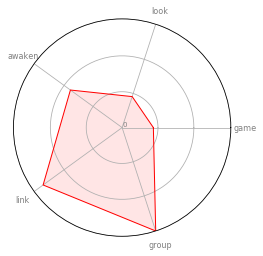

In [39]:
automating_radar_plots(df, start_time=start_time, end_time=end_time, which_five='top')

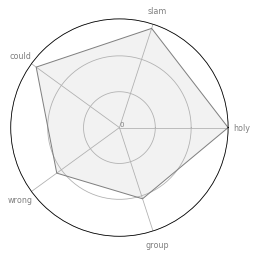

In [40]:
automating_radar_plots(df, start_time=start_time, end_time=end_time, which_five='bottom')

# Experimental

In [ ]:
#df.loc[df['time'] == '16:07:00']

In [ ]:
tweet_df = pd.DataFrame(tweets)

In [ ]:
print(tweet_df['created_at'].min())
print(tweet_df['created_at'].max())


In [ ]:
tweet_df['text']

In [ ]:
tweet_df.iloc[-1]['created_at']

In [ ]:
tweet_df['timestamp'] = tweet_df['created_at'].apply(pd.Timestamp)

In [ ]:
tweet_df.loc[tweet_df['timestamp'] == 'Tue Jun 11 16:33:25 +0000 2019']